### Implementation of the codes developed, openTURNS style


In [1]:
import openturns as ot
import numpy as np

We will use again the example developed, concerning the bending beam with random structural parameters. 
There will be some key differences with the first pipeline, as we will limit ourselves to a subset of the cases treated, and  not write some 'omnipotent' code.

In this new case, we will study the influence of each compônent of an aggreagated process (a collection of processes  each defined on a same shaped mesh), on a other aggregated process, by computing sobol sobol indices. 

To mimic other behaviours we can : 
    - Define a scalar random variable as a constant field or vector
    
###### Class will be intialized as so:
myAnalysis = ot.newSaltelliSensitivityAlgorithm(AggregatedProcess, FieldFunction, N, computeSecondOrder) 

This beahviour is based on the existing class: ot.SaltelliSensitivityAlgorithm






ot.RandomGenerator.SetSeed(0) 

baseDim = 1 #dimension of our process, the beam is 1D


# we have 2 processes in our problem, initially
#For young modulus:
amplitude = [5000]
scale = [300]
nu = 13/3
Model = MaternModel 

#For diameter:


In [2]:
# First step : DEFINING THE PROCESSES AND RANDOM VARIABLES
# First Process E_ : Youngs modulus
# dimension 
dimension = 1
#grid
#Number of elements:
NElem = [100]
mesher = ot.IntervalMesher(NElem)
lowBound = [0] #mm
highBound = [1000] #mm
interval = ot.Interval(lowBound,highBound)
mesh = mesher.build(interval)

#Covariance model Young's modulus
amplitude0 = [50000]*dimension
scale0 = [300]*dimension
nu0 = 13/3
model0 = ot.MaternModel(scale0, amplitude0, nu0)
# Karhunen Loeve decomposition of process 
algorithm = ot.KarhunenLoeveP1Algorithm(mesh, model0, 1e-3)
algorithm.run()
resultsE = algorithm.getResult()
resultsE.setName('E_')

# Second Process D_ : Diameter
amplitude = [.3]*dimension
scale = [250]*dimension
nu = 13/3
model1 = ot.MaternModel(scale, amplitude, nu)
algorithm = ot.KarhunenLoeveP1Algorithm(mesh, model1, 1e-3)
algorithm.run()
resultsD = algorithm.getResult()
resultsD.setName('D_')



def variablesAsProcess(distribution, mesh):
    '''Function to transform a scalar distribution into 
    a constant process defined over a mesh
    '''
    basis = ot.Basis([ot.SymbolicFunction(['x'],['1'])])
    lawAsprocess = ot.FunctionalBasisProcess(distribution, basis, mesh)
    lawAsprocess.setName(distribution.getName())
    return lawAsprocess

# First we define the distributions
# random variable for the density of the material (kg/m³)
sigma       = 750
nameD       = 'Rho'
RV_Rho = ot.Normal(0, sigma)
RV_Rho.setName(nameD)
# random variable for the position of the force   (mm) 
sigma_f      = 50
namePos     = 'FP'
RV_Fpos = ot.Normal(0, sigma_f)
RV_Fpos.setName(namePos)
# random variable for the norm of the force    (N)
sigma_Fnor    = 5.5
nameNor       = 'FN'
RV_Fnorm  = ot.Normal(0, sigma_Fnor)
RV_Fnorm.setName(nameNor)

# Then convert the distributions t processes over a mesh
SP_Rho = variablesAsProcess(RV_Rho, mesh)
SP_Fpos = variablesAsProcess(RV_Fpos, mesh)
SP_Fnorm = variablesAsProcess(RV_Fnorm, mesh)

# Then we can do the Karhunen Loeve decomposition of the distribution
algorithm0 = ot.KarhunenLoeveP1Algorithm(mesh, SP_Rho.getCovarianceModel(), 1e-3)
#algorithm0.setNbModes(1)
algorithm0.run()
resultsRho = algorithm0.getResult()
resultsRho.setName('Rho_')

algorithm1 = ot.KarhunenLoeveP1Algorithm(mesh, SP_Fpos.getCovarianceModel(), 1e-3)
#algorithm1.setNbModes(1)
algorithm1.run()
resultsFpos = algorithm1.getResult()
resultsFpos.setName('Fpos_')

algorithm2 = ot.KarhunenLoeveP1Algorithm(mesh, SP_Fnorm.getCovarianceModel(), 1e-3)
#algorithm2.setNbModes(1)
algorithm2.run()
resultsFnor = algorithm2.getResult()
resultsFnor.setName('Fnorm_')

# Finally we get a list of aggregated KarhunenLoeve results
listOfKLRes = [resultsE, resultsD, resultsRho, resultsFpos, resultsFnor]


In [3]:
resultsE

class=KarhunenLoeveResultImplementation covariance model=class=MaternModel scale=class=Point name=Unnamed dimension=1 values=[300] amplitude=class=Point name=Unnamed dimension=1 values=[50000] nu=4.33333 threshold=0.001 eigenvalues=class=Point name=Unnamed dimension=7 values=[1.41923e+12,7.0656e+11,2.58952e+11,8.06386e+10,2.37086e+10,7.02051e+09,2.16944e+09] modes=[class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,y0] evaluationImplementation=class=PiecewiseLinearEvaluation locations=class=Point name=Unnamed dimension=101 values=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540,550,560,570,580,590,600,610,620,630,640,650,660,670,680,690,700,710,720,730,740,750,760,770,780,790,800,810,820,830,840,850,860,870,880,890,900,910,920,930,940,950,960,970,980,990,1000] values=class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=101 dimension=1 data=[[0.0188981],[0.0194716],[0.0200482],[0.020627],[0.0212073],[0.0217884],[0.0223694],[0.0229497],[0.0235283],[0.0241045],[0.0246775],[0.0252466],[0.0258109],[0.0263698],[0.0269225],[0.0274683],[0.0280064],[0.0285362],[0.029057],[0.0295682],[0.0300692],[0.0305592],[0.0310379],[0.0315045],[0.0319585],[0.0323995],[0.032827],[0.0332404],[0.0336394],[0.0340235],[0.0343923],[0.0347454],[0.0350824],[0.0354031],[0.0357071],[0.0359941],[0.0362639],[0.0365161],[0.0367506],[0.0369671],[0.0371654],[0.0373454],[0.0375069],[0.0376497],[0.0377737],[0.0378788],[0.037965],[0.038032],[0.03808],[0.0381088],[0.0381184],[0.0381088],[0.03808],[0.038032],[0.037965],[0.0378788],[0.0377737],[0.0376497],[0.0375069],[0.0373454],[0.0371654],[0.0369671],[0.0367506],[0.0365161],[0.0362639],[0.0359941],[0.0357071],[0.0354031],[0.0350824],[0.0347454],[0.0343923],[0.0340235],[0.0336394],[0.0332404],[0.032827],[0.0323995],[0.0319585],[0.0315045],[0.0310379],[0.0305592],[0.0300692],[0.0295682],[0.029057],[0.0285362],[0.0280064],[0.0274683],[0.0269225],[0.0263698],[0.0258109],[0.0252466],[0.0246775],[0.0241045],[0.0235283],[0.0229497],[0.0223694],[0.0217884],[0.0212073],[0.020627],[0.0200482],[0.0194716],[0.0188981]] gradientImplementation=class=CenteredFiniteDifferenceGradient name=Unnamed epsilon=class=Point name=Unnamed dimension=1 values=[1e-05] evaluation=class=PiecewiseLinearEvaluation locations=class=Point name=Unnamed dimension=101 values=[0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,310,320,330,340,350,360,370,380,390,400,410,420,430,440,450,460,470,480,490,500,510,520,530,540,550,560,570,580,590,600,610,620,630,640,650,660,670,680,690,700,710,720,730,740,750,760,770,780,790,800,810,820,830,840,850,860,870,880,890,900,910,920,930,940,950,960,970,980,990,1000] values=class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=101 dimension=1 data=[[0.0188981],[0.0194716],[0.0200482],[0.020627],[0.0212073],[0.0217884],[0.0223694],[0.0229497],[0.0235283],[0.0241045],[0.0246775],[0.0252466],[0.0258109],[0.0263698],[0.0269225],[0.0274683],[0.0280064],[0.0285362],[0.029057],[0.0295682],[0.0300692],[0.0305592],[0.0310379],[0.0315045],[0.0319585],[0.0323995],[0.032827],[0.0332404],[0.0336394],[0.0340235],[0.0343923],[0.0347454],[0.0350824],[0.0354031],[0.0357071],[0.0359941],[0.0362639],[0.0365161],[0.0367506],[0.0369671],[0.0371654],[0.0373454],[0.0375069],[0.0376497],[0.0377737],[0.0378788],[0.037965],[0.038032],[0.03808],[0.0381088],[0.0381184],[0.0381088],[0.03808],[0.038032],[0.037965],[0.0378788],[0.0377737],[0.0376497],[0.0375069],[0.0373454],[0.0371654],[0.0369671],[0.0367506],[0.0365161],[0.0362639],[0.0359941],[0.0357071],[0.0354031],[0.0350824],[0.0347454],[0.0343923],[0.0340235],[0.0336394],[0.0332404],[0.032827],[0.0323995],[0.0319585],[0.0315045],[0.0310379],[0.0305592],[0.0300692]

### NOTE :

When defining a distribution as a process, as shown above, it is of utmost importance to modifiy his function so that it takes as an input a constant process, not a distribution anymore. This can also be easily avoided, if you take the first value of the field generated.

###### Always multiple ways to proceed :

In the example presented here, 2 ways of approaching the problem are possible. First we can create all our processes individually, decompose them individually with Karhunen Loeve, and pass a list of KarhunenLoeveResults to our new function wrapper. 
But this is only necessary if we would have meshes of different shapes, or if we would have defined the scalar distributions on smaller meshes. But as all processes are defined over the same mesh here, we could have aggregated the Processes, and directly decompose the AggregatedProcess. 

###### Note2 :

When using the **KarhunenLoeveP1Algorithm** function, only the covariance function is decomposed this means **all data 'bout the means and the trend functions are FORGOTTEN**. You have to add these constants **Directly in yout function!** 


In [4]:
# Example function imports
import PureBeamExample as pbe
import KarhunenLoeveFieldSensitivity as klfs

##### First tests with new architecture. 
our base is a list of Karhunen Loeve Results. This will be passed into a contructor called AggregatedKarhunenLoeveResults. This  class is necessary as it is used to pass between the one dimensional space of the KarhunenLoeve Coefficients to the arbitrary dimension of the field linked to it. 
This class keeps all the data about the decomposition and allows to work on lists of processes

In [5]:
AggregatedKLObj = klfs.AggregatedKarhunenLoeveResults(listOfKLRes)

In [6]:
# Now we only need a vector of centered normal distributions to mimic the entire behaviour of our 2 fields
# and 3 random variables
Vector = ot.ComposedDistribution([ot.Normal()]*AggregatedKLObj.getSizeModes())

##### Now we can use our wrapper to transform our example function, the model of the bending beam, wher 2 of it's parameters are stochastic_fields . 

In [7]:
## First: beam initialization with mesh
PureBeam = pbe.PureBeam(mesh)

In [8]:
# Now that we have our function, we can pass it in our wrapper! 
FUNC = klfs.KarhunenLoeveGeneralizedFunctionWrapper(AggregatedKarhunenLoeveResults=AggregatedKLObj,
                                             func=PureBeam.singleEval, func_sample=PureBeam.batchEval,
                                             outputDim=2)
FUNC

### Now that we have the new representation of our function, we can begin to create our experiment. 
For this, we use our class called **KarhunenLoeveSobolIndicesExperiment**. This last class aims to be similar to the class SobolIndicesExperiment. 

In [9]:
SobolExp = klfs.KarhunenLoeveSobolIndicesExperiment(AggregatedKLObj, 30,False)

In [10]:
experiment = SobolExp.generate()
experiment

Samples A and B of size 30 and dimension 18
Experiment of size 210 and dimension 18


class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=210 dimension=18 description=[E__0,E__1,E__2,...,Rho__0,Fpos__0,Fnorm__0] data=[[0.608202,1.67297,-2.4067,...,2.31733,0.929992,-0.638673],[-1.26617,-1.03896,0.662936,...,-0.469879,-0.483778,-0.260154],[-0.438266,-0.353552,-0.65616,...,-0.801703,-0.174459,-1.43577],...,[1.78236,-0.938771,0.729688,...,-0.707992,-0.863809,-0.383809],[0.0702074,-1.96869,-0.247234,...,-0.836693,1.23659,-0.135983],[-0.781366,-0.657603,0.479191,...,-0.08448,1.40946,-0.966214]]

In [11]:
output = FUNC(experiment)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:   

shape deflection:  (210, 103)  should be [N,10X] something
deflection std deviation  5.025700218049718
Using the batch evaluation function. Assumes that the outputs are in the 
same order than for the single evaluation function. This one should only 
return ProcessSamples, Samples, Lists or numpy arrays.
Element is iterable, assumes that first dimension is size of sample
Shape is (210, 102) and dtype is <class 'numpy.float64'>
Element 0 of the output tuple returns process samples of dimension 1
Element is iterable, assumes that first dimension is size of sample
Shape is (210,) and dtype is <class 'numpy.float64'>
Element 1 of the output tuple returns samples of dimension 1


[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:   17.2s finished
/home/simady/anaconda/envs/stochastic_field_env/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [12]:
from importlib import reload
reload(klfs)
test = klfs.SaltelliKLFieldSensitivityAlgorithm(experiment, output, 30)

if you plan to pass the data to compute it
Otherwise, the behavior may be unexpected
Class appended
Class appended
There are 5 indices to get for 2 outputs with dimensions 102, 1 each.
SobolIndicesName ['Fpos__', 'Rho__', 'D__', 'Fnorm__', 'E__']


In [14]:
X = test.getSobolIndices(test.__preProcessedOutputDesign__)

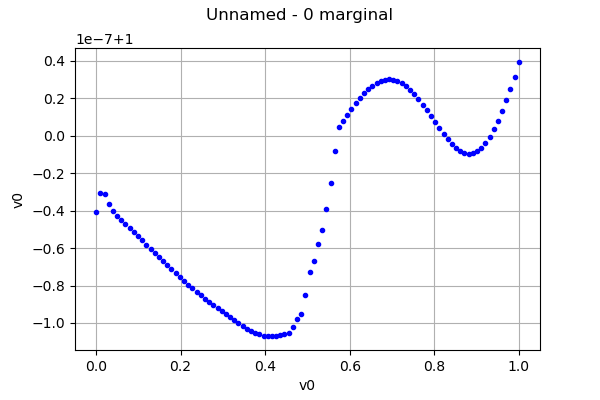

In [15]:
X[0][0][0].draw()

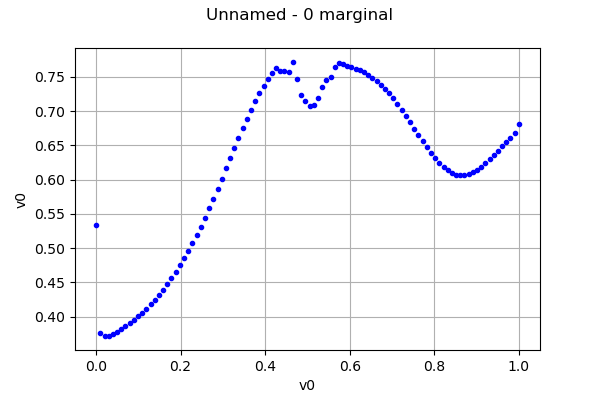

In [16]:
X[0][0][1].draw()

In [ ]:
X[0][0][2].draw()

In [ ]:
X[0][0][3].draw()

In [ ]:
X[0][0][4].draw()

In [ ]:
def plot_monte_carlo_res_mult(monteCarloResults_elem=None,
                              monteCarloResults_node=None,
                              monteCarloResults_glob=None,
                              VMStress=None, t_plt = 0.1):
    monteCarloResults_elem = monteCarloResults_elem
    monteCarloResults_node = monteCarloResults_node
    monteCarloResults_glob = monteCarloResults_glob
    vonMisesStress_MC      = VMStress
    X_elem0 = monteCarloResults_elem[0,0,:]
    X_node0 = monteCarloResults_node[0,0,:]
    images = []
    pyplot.ion()
    fig = pyplot.figure(figsize=(20,10))

    # graphs on grid
    graph1 = pyplot.subplot2grid((6,7),(0,0),colspan = 3 ,rowspan = 2 ,fig = fig) 
    graph2 = pyplot.subplot2grid((6,7),(2,0),colspan = 3 ,rowspan = 2 ,fig = fig)
    graph3 = pyplot.subplot2grid((6,7),(0,3),colspan = 3 ,rowspan = 2 ,fig = fig)
    graph4 = pyplot.subplot2grid((6,7),(2,3),colspan = 3 ,rowspan = 2 ,fig = fig)
    graph5 = pyplot.subplot2grid((6,7),(4,3),colspan = 3 ,rowspan = 2 ,fig = fig)
    graph6 = pyplot.subplot2grid((6,7),(4,0),colspan = 3 ,rowspan = 2 ,fig = fig)
    graph7 = pyplot.subplot2grid((6,7),(0,6),colspan = 1 ,rowspan = 3 ,fig = fig)
    graph8 = pyplot.subplot2grid((6,7),(3,6),colspan = 1 ,rowspan = 3 ,fig = fig)

    # define titles
    graph1.set_title('Young Modulus (MPa)'    , fontsize = 10)
    graph2.set_title('Diameter (mm)'          , fontsize = 10)
    graph3.set_title('Shear (N)'              , fontsize = 10)
    graph4.set_title('Moment (N.mm)'          , fontsize = 10)
    graph5.set_title('Deflection (mm)'        , fontsize = 10)
    graph6.set_title('Von Mises Stress (MPa)' , fontsize = 10)
    graph7.set_title('Applied force (N)'      , fontsize = 10)
    graph8.set_title('Density (kg/m³)'        , fontsize = 10)

    color_dict = {1:'r-', 2:'g--', 3:'b-.', 4:'m:', 5:'c-'}
    color_dict2= {1:'r', 2:'g', 3:'b', 4:'m', 5:'c'}
    ##define graphs
    lines1 = [graph1.plot(X_elem0, monteCarloResults_elem[i,1,:], color_dict[i+1])[0] for i in range(5)]
    lines2 = [graph2.plot(X_elem0, monteCarloResults_elem[i,2,:], color_dict[i+1])[0] for i in range(5)]
    lines3 = [graph3.plot(X_elem0, monteCarloResults_elem[i,3,:], color_dict[i+1])[0] for i in range(5)]
    lines4 = [graph4.plot(X_elem0, monteCarloResults_elem[i,4,:], color_dict[i+1])[0] for i in range(5)]
    lines5 = [graph5.plot(X_node0, monteCarloResults_node[i,1,:], color_dict[i+1])[0] for i in range(5)]
    lines6 = [graph6.plot(X_elem0, vonMisesStress_MC[i,:]       , color_dict[i+1])[0] for i in range(5)]
    barsh7 = graph7.barh(y = [0,1,2,3,4], width = monteCarloResults_glob[0:5,0], height = 0.8, align = 'edge', color = [color_dict2[i+1] for i in range(5)])  
    barsh8 = graph8.barh(y = [0,1,2,3,4], width = monteCarloResults_glob[0:5,1], height = 0.8, align = 'edge', color = [color_dict2[i+1] for i in range(5)])  


    axvlines1 = [graph1.axvline(x = monteCarloResults_glob[i,2], c = color_dict2[i+1]) for i in range(5)]
    axvlines2 = [graph2.axvline(x = monteCarloResults_glob[i,2], c = color_dict2[i+1]) for i in range(5)]
    axvlines3 = [graph3.axvline(x = monteCarloResults_glob[i,2], c = color_dict2[i+1]) for i in range(5)]
    axvlines4 = [graph4.axvline(x = monteCarloResults_glob[i,2], c = color_dict2[i+1]) for i in range(5)]
    axvlines5 = [graph5.axvline(x = monteCarloResults_glob[i,2], c = color_dict2[i+1]) for i in range(5)]
    axvlines6 = [graph6.axvline(x = monteCarloResults_glob[i,2], c = color_dict2[i+1]) for i in range(5)]
    fig.subplots_adjust(hspace=0.25,wspace=0.25)
    pyplot.tight_layout()
    fig.canvas.draw()
    pyplot.pause(t_plt)
    fig.canvas.flush_events()

    for i in range(5, monteCarloResults_elem.shape[0], 5):
        [lines1[k].set_xdata(monteCarloResults_elem[i+k,0,:])  for k in range(5)]
        [lines2[k].set_xdata(monteCarloResults_elem[i+k,0,:])  for k in range(5)]
        [lines3[k].set_xdata(monteCarloResults_elem[i+k,0,:])  for k in range(5)]
        [lines4[k].set_xdata(monteCarloResults_elem[i+k,0,:])  for k in range(5)]
        [lines5[k].set_xdata(monteCarloResults_node[i+k,0,:])  for k in range(5)]
        [lines6[k].set_xdata(monteCarloResults_elem[i+k,0,:])  for k in range(5)]

        [lines1[k].set_ydata(monteCarloResults_elem[i+k,1,:])  for k in range(5)]
        [lines2[k].set_ydata(monteCarloResults_elem[i+k,2,:])  for k in range(5)]
        [lines3[k].set_ydata(monteCarloResults_elem[i+k,3,:])  for k in range(5)]
        [lines4[k].set_ydata(monteCarloResults_elem[i+k,4,:])  for k in range(5)]
        [lines5[k].set_ydata(monteCarloResults_node[i+k,1,:])  for k in range(5)]
        [lines6[k].set_ydata(vonMisesStress_MC[i+k,:])         for k in range(5)]

        [axvlines1[k].set_xdata(monteCarloResults_glob[i+k,2]) for k in range(5)]
        [axvlines2[k].set_xdata(monteCarloResults_glob[i+k,2]) for k in range(5)]
        [axvlines3[k].set_xdata(monteCarloResults_glob[i+k,2]) for k in range(5)]
        [axvlines4[k].set_xdata(monteCarloResults_glob[i+k,2]) for k in range(5)]
        [axvlines5[k].set_xdata(monteCarloResults_glob[i+k,2]) for k in range(5)]
        [axvlines6[k].set_xdata(monteCarloResults_glob[i+k,2]) for k in range(5)]

        for rect, h in zip(barsh7, monteCarloResults_glob[i:i+5,0]):
            rect.set_width(h)
        for rect, h in zip(barsh8, monteCarloResults_glob[i:i+5,1]):
            rect.set_width(h)

        graph1.relim()
        graph2.relim()
        graph3.relim()
        graph4.relim()
        graph5.relim()
        graph6.relim()
        graph7.relim()
        graph8.relim()
        graph1.autoscale_view()
        graph2.autoscale_view()
        graph3.autoscale_view()
        graph4.autoscale_view()
        graph5.autoscale_view()
        graph6.autoscale_view()
        graph7.autoscale_view()
        graph8.autoscale_view()
        fig.canvas.draw()
        pyplot.pause(t_plt)
        fig.canvas.flush_events()

    return images